# Object Localization

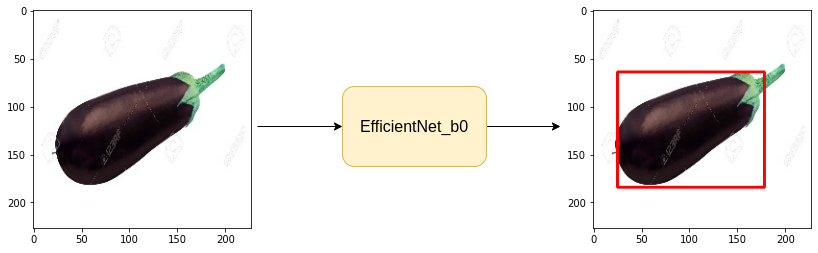

In [7]:
# install libraries/packages/modules

#!pip install -U git+https://github.com/albumentations-team/albumentations
#!pip install timm
#!pip install --upgrade opencv-contrib-python

In [1]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
 Receiving objects:  68% (139/203), 1.46 MiB | 1.44 MiB/sReceiving objects:  71% (145/203), 1.46 MiB | 1.44 MiB/sReceiving objects:  73% (149/203), 1.46 MiB | 1.44 MiB/sReceiving objects:  79% (161/203), 1.46 MiB | 1.44 MiB/sReceiving objects:  81% (165/203), 1.46 MiB | 1.44 MiB/sReceiving objects:  84% (171/203), 1.46 MiB | 1.44 MiB/sReceiving objects:  87% (177/203), 1.46 MiB | 1.44 MiB/sReceiving objects:  89% (181/203), 1.46 MiB | 1.44 MiB/sReceiving objects:  93% (189/203), 2.35 MiB | 1.54 MiB/sremote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 1.61 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
import sys
sys.path.append('object-localization-dataset')

# Configurations

In [3]:
CSV_FILE = 'object-localization-dataset/train.csv'
DATA_DIR = 'object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

# number of coordinates
NUM_COR = 4

# Understand the dataset

In [4]:
# loading the data from the CSV file
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


In [5]:
row = df.iloc[2]
DATA_DIR + row.img_path

'object-localization-dataset/train_images/mushroom_20.jpg'

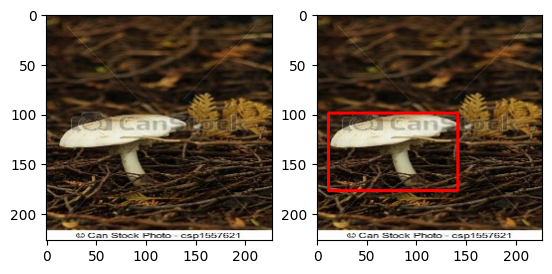

In [7]:
# selecting a row from the dataframe
row = df.iloc[34]
# using the img_path data to create the image path
img = cv2.imread(DATA_DIR + row.img_path)
# changing the color space of the image from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# showing only the image
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img)

# extracting the points for the bounding box
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
# setting the bounding box
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2) 
# showing the image with its bounding box
ax2.imshow(bnd_box_img)

In [8]:
# Spliting the data set. Since it dataset is small (185 images), the validation set will be used for testing.

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [9]:
import albumentations as A

In [10]:
# train augmentation

train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [11]:
# validation augementation

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [12]:


class ObjLocDataset(torch.utils.data.Dataset):

    def __init__(self, dataframe, aumens = None):
        self.df = dataframe
        self.aumentations = aumens

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row_df = self.df.iloc[idx]

        xmin = row_df.xmin
        ymin = row_df.ymin
        xmax = row_df.xmax
        ymax = row_df.ymax

        bbox_in = [[xmin, ymin, xmax, ymax]]

        img_path = DATA_DIR + row_df.img_path
        img_in = cv2.imread(img_path)
        img_in = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)

        if self.aumentations:
            data = self.aumentations(image=img_in, bboxes=bbox_in, class_labels=[None])
            img_in = data['image']
            bbox_in = data['bboxes'][0]

        img_in = torch.from_numpy(img_in).permute(2,0,1)/ 255.0 # (h,w,c) -> (c,h,w)
        bbox_in = torch.Tensor(bbox_in)

        return img_in, bbox_in

In [13]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [14]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the validset: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


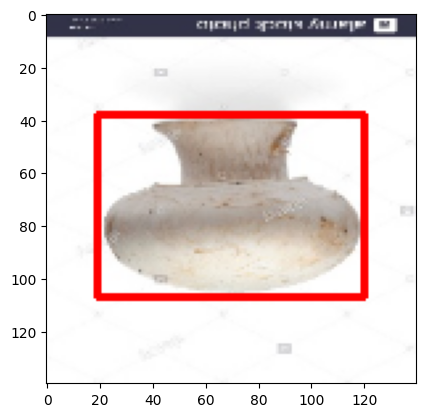

In [16]:
img, bbox = trainset[8]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [17]:
# loading traindataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
# loading validation dataset
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [19]:
for images, bboxes in trainloader:
    break;

print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [20]:
from torch import nn
import timm

In [21]:
#

class ObjLocModel(nn.Module):

    def __init__(self,
                 model_name: str = MODEL_NAME,
                 output_dim: int=NUM_COR,
                 pretrained: bool=True,
                 loss_fn: nn.Module=None):
        super(ObjLocModel,self).__init__()
        # instantiation backbone with a new head
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=output_dim)
        self.criterion = loss_fn or nn.MSELoss()

    def forward(self, images, gt_bboxes=None):
        preds = self.backbone(images)

        if gt_bboxes is not None:
            loss = self.criterion(preds, gt_bboxes)
            return preds, loss
            
        return preds

In [22]:
model = ObjLocModel()
model.to(DEVICE)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

In [23]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [34]:
# training function

def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() # this mean that Dropout ON
    for data in tqdm(dataloader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss/len(dataloader)

In [28]:
# evaluation function

def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval() # this mean that Dropout OFF
    with torch.no_grad():
        for data in tqdm(dataloader):
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

            bboxes, loss = model(images, gt_bboxes)
            total_loss += loss.item()

    return total_loss/len(dataloader)

# Training Loop

# Training Loop

In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [36]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)
    if valid_loss < train_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("WEIGHTS-ARE-SAVED")
        best_valid_loss = valid_loss
    print(f"Epoch: {i + 1} train loss: {train_loss} valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 train loss: 1855.6982299804688 valid loss: 2191.9971923828125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 2 train loss: 944.3691284179688 valid loss: 533.1413777669271


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 3 train loss: 615.7213500976562 valid loss: 159.60103352864584


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 4 train loss: 412.07420349121094 valid loss: 118.42051951090495


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 5 train loss: 309.00963287353517 valid loss: 120.87314860026042


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 6 train loss: 211.65044555664062 valid loss: 148.7264149983724


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 7 train loss: 168.55418853759767 valid loss: 95.08120854695638


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 8 train loss: 129.07700271606444 valid loss: 125.57311757405598


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 train loss: 97.5658950805664 valid loss: 110.02779642740886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 10 train loss: 92.90792465209961 valid loss: 77.55023701985677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 11 train loss: 84.52714004516602 valid loss: 75.0478884379069


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 train loss: 76.47162437438965 valid loss: 76.9856783548991


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 train loss: 73.28350830078125 valid loss: 74.58661270141602


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 train loss: 73.56561851501465 valid loss: 103.91589609781902


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 15 train loss: 97.02493667602539 valid loss: 77.27201588948567


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 train loss: 57.903987121582034 valid loss: 70.13745053609212


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 train loss: 46.316450881958005 valid loss: 105.51870981852214


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 18 train loss: 61.35990180969238 valid loss: 60.81613349914551


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 train loss: 49.40202445983887 valid loss: 52.818712870279946


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 train loss: 43.18002624511719 valid loss: 54.85434150695801


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 train loss: 36.43414363861084 valid loss: 41.05678176879883


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 train loss: 42.138648223876956 valid loss: 59.79780069986979


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 train loss: 44.03208770751953 valid loss: 68.09296162923177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 train loss: 43.97623176574707 valid loss: 57.697469075520836


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 train loss: 38.15655994415283 valid loss: 54.915292739868164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 train loss: 27.579365158081053 valid loss: 46.76608149210612


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 train loss: 35.813484573364256 valid loss: 48.37668800354004


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 train loss: 41.062308883666994 valid loss: 46.4217783610026


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 29 train loss: 49.3370719909668 valid loss: 42.85211308797201


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 train loss: 31.273933029174806 valid loss: 48.93626276652018


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 train loss: 28.500451850891114 valid loss: 39.164170583089195


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epoch: 32 train loss: 51.464579582214355 valid loss: 41.315816243489586


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 train loss: 30.66945924758911 valid loss: 44.26093673706055


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 train loss: 29.581767082214355 valid loss: 71.11444600423177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 train loss: 29.33701992034912 valid loss: 37.86092185974121


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 train loss: 31.13076171875 valid loss: 34.71980539957682


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 train loss: 34.084936904907224 valid loss: 58.166586558024086


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 train loss: 29.784103107452392 valid loss: 51.53553009033203


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 train loss: 29.475312423706054 valid loss: 40.17802302042643


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 train loss: 37.21917381286621 valid loss: 54.4019660949707


# Inference

In [32]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


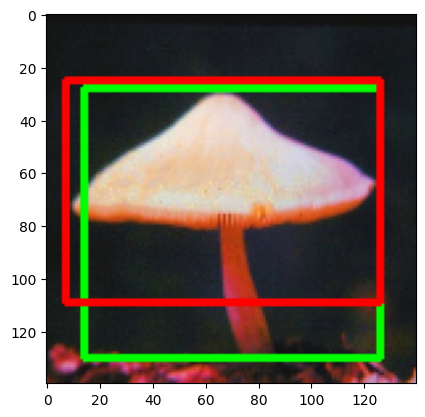

In [41]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    image, gt_bbox = validset[5] # (c, h, w)
    image = image.unsqueeze(0).to(DEVICE) # (bs, c, h, w)
    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)